<div class="alert alert-info">
    <h2>Project</h2>
        <p> Here at the OilyGiant Mining Company We are trying to find the best place for a new well. </p>
    <h3>Goal</h3>
    <p>We are going to collect the oil well parameters in the selected region witht he oil quality and volume of reserves.
    Then build a model to predict the volume in the new wells. Pick the oil wells with the highest estimated values. Pick the the region with the highest profit for the selected well locations. The data we have are oil samples from three regions. the parameters are already known so we will build a model that will help pick the region with the highest profit margin and analyze potential profits and risk using the bootstrapping technique</p>
</div>


In [1]:
#Let us first import the relevant libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from joblib import dump
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy import stats as st

<div class="alert alert-info">
    <h3>Download and Prepare Data</h3>
        <p></p>
</div>

In [2]:
#Now, let us load the data
df0 = pd.read_csv('/datasets/geo_data_0.csv')

df1 = pd.read_csv('/datasets/geo_data_1.csv')

df2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
df0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
df1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [5]:
df2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [6]:
#All helper functions are created in this code chunk to keep the rest of the report neat

#This function gives us a premilinary glimpse into the data
def inspect_data(df):
    print(df.head())
    print(df.isna().sum())
    print(df.info())
    print(df.describe())

#This function divides the data into a training and testing set for features and target, in a ratio of 75:25 and outputs the length of the resulting dataset
def split_data(df):
    features = df.drop(columns=['product', 'id'])
    target =  df["product"]
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345)
    print('Outputting the lengths of the split datasets:')
    print(len(features_train))
    print(len(target_train))
    print(len(features_test))
    print(len(target_test))
    return features_train, features_test, target_train, target_test

#This function takes the testing and training data of the features and target, normalizes the data, and then
#fits it to a linear regression model. It then outputs the R2, RMSE and mean predicted scores.
def lin_reg(features_train, features_test, target_train, target_test):
    to_normalize = ['f0','f1','f2']
    scaler = StandardScaler()
    scaler.fit(features_train[to_normalize])
    features_train.loc[:,to_normalize] = scaler.transform(features_train[to_normalize])
    features_test.loc[:,to_normalize] = scaler.transform(features_test[to_normalize])
    lr = LinearRegression().fit(features_train,target_train)
    predicted_values = lr.predict(features_test)
    print('R2', lr.score(features_test, target_test))
    print('RMSE:', np.sqrt(mean_squared_error(target_test, predicted_values)))
    print('Average Volume of Predicted Reserve:',predicted_values.mean() )
    return predicted_values

#This function calculates the profit generated based on the volume of oil in a particular region.

def profit(target, probabilities):
    target = pd.Series(target).reset_index(drop=True)
    probabilities = pd.Series(probabilities)
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:n_best]
    return (selected.sum()* (price*unit)) - bud

#This function takes in the same argruments as the profit calculate function in additon to the number of outputs needed.
#The output is the wells with the highest predictions.
def highest_wells(target, probabilities,number):
    target = pd.Series(target).reset_index(drop=True)
    probabilities = pd.Series(probabilities)
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:n_best]
    return selected.head(number)
    
#This function uses bootstrapping to generate a vector of how much profit can be generated based on smaller random subsets.
#It returns a vector of the profits of each sample
def bs_profit(target, probabilities):
    profits = []
    target = pd.Series(target).reset_index(drop=True)
    state = np.random.RandomState(12345)
    for i in range(1000):
        target_subsample = target.sample(n=n, replace=True, random_state = state)
        probs_subsample = probabilities[target_subsample.index]
        profits.append(profit(target_subsample, probs_subsample))

    profits = pd.Series(profits)
    print('Wells that make a profit:',profits.gt(0).sum())
    print('Proportion of wells that make a profit:', profits.gt(0).sum()/len(profits))
    
    profits.hist()
    plt.suptitle('Histogram of how many bootstrap samples make a profit', x=0.5, y=1.05, ha='center', fontsize='xx-large')

    return profits

#This function takes the output of the bs_profits function and outputs a confidence interval, the average profit and 
#the risk of loss for a particular region.
def conf_int(profits):
    ci = st.t.interval(0.95, len(profits)-1, profits.mean(), profits.sem())
    risk = len(profits[profits < 0]) / len(profits)
    print('The average profit for this region is: ',profits.mean())
    print('The 95% confidence interval is:', ci[0], ',' ,ci[1] )
    print('The risk of losses is', risk)
    
def bs_conf_int(profits):

    
    lower = profits.quantile(0.025)
    upper = profits.quantile(0.975)
    print('Confidence interval from the quantile method:', lower, ',',upper)

In [7]:
inspect_data(df0)

      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.5

In [8]:
inspect_data(df1)

      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.7965

In [9]:
inspect_data(df2)

      id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.002023      -0.002081       2.4

<div class="alert alert-info">
    <h3>Download and Prepare Data Summary</h3>
        <p>The data is in great shape able to take straight to modeling. There are no null values and the data types of the columns are good as well as the outliers/means.</p>
</div>

<div class="alert alert-info">
    <h2>Train and Test Model for Each Region</h2>
        <p>we are going to split the data into a training set and validation set ratio of a 75:25.</p>
</div>


In [10]:
features_train0, features_test0, target_train0, target_test0 = split_data(df0)

Outputting the lengths of the split datasets:
75000
75000
25000
25000


In [11]:
features_train1,  features_test1, target_train1, target_test1 = split_data(df1)

Outputting the lengths of the split datasets:
75000
75000
25000
25000


In [12]:
features_train2,  features_test2, target_train2,  target_test2 = split_data(df2)

Outputting the lengths of the split datasets:
75000
75000
25000
25000


<div class="alert alert-info">
    <h3>Make Predictions for Validation Set</h3>
        <p>we will save the predictions and correct answers for the validation set and print the average volume of predicted reserves and model RMSE. </p>
</div>


In [13]:
predicted_values0 = lin_reg(features_train0, features_test0, target_train0, target_test0)

R2 0.27994321524487786
RMSE: 37.5794217150813
Average Volume of Predicted Reserve: 92.59256778438035


In [14]:
predicted_values1 = lin_reg(features_train1, features_test1, target_train1, target_test1)

R2 0.9996233978805127
RMSE: 0.893099286775617
Average Volume of Predicted Reserve: 68.728546895446


In [15]:
predicted_values2 = lin_reg(features_train2, features_test2, target_train2, target_test2)

R2 0.20524758386040443
RMSE: 40.02970873393434
Average Volume of Predicted Reserve: 94.96504596800489


<div class="alert alert-info">
    <h3>Predictions for Validation Sets Summary</h3>
        <p>The steps are all completed by the function above. The coefficient of determinaton or the R2 metric divides the Model MSE by the Mean MSE and then subtracts the values from one. if the metric increases the models quality improves as well. The first and third regions have a lower R squared metric with 0.28 and 0.21. The RMSE is related to the R2 so the results also reflect that. The average value for the first region is 92.59 for the second region its 68.73 and for the third region its 94.96 this means that the preferred regions would be the first and third. with the caveat that the models also make more erros for those regions.</p>
</div>


<div class="alert alert-info">
    <h2>Calculating Profit</h2>
        <p>We are going to store all the key values for the calculations in seperate variables. We will calculate the volume of reserves suffiecient for developing a new well without losses. Then compare the obtained value with the average volume of reserves in each region. There are conditions we need to follow which means that linear regression is the best for the training model. The rest are not as sufficient in predictability. When we are exploring the region a study of 500 points is carried with the best 200 points for the profit calculation. We also have a budget for development of 200 oil wells which is 100 million US dollars. one barrell of raw material is 4.5 usdollars of revenue. From the revenue of one unit is 4,500 dollars the volume of the reserves is in thousand barrels. After we evaluate the risk we will only keep the regions with the risk loss lower then 2.5%. Then from there the one that fits the criteria of region with the highest average profit will be selected.</p>
</div>


In [16]:
n = 500
n_best = 200
n_wells = 200
bud = 100000000
price = 4.5
unit = 1000
risk = 0.025
print('The volume of reserves sufficient for developing a new well without losses is:', bud/n_best/(price*unit))

The volume of reserves sufficient for developing a new well without losses is: 111.11111111111111


<div class="alert alert-info">
    <h3>Calculations Summary</h3>
        <p>This calculation is only based on a worst case scenario, this gives us an estimate of a safe investment. We have two regions that are pretty close to this value, so this is good news.</p>
</div>



<div class="alert alert-info">
    <h3>Profit From Specific wells</h3>
        <p></p>
</div>

In [17]:
#Profit for region 1:
profit(target_test0, predicted_values0)

33208260.43139851

In [18]:
#Profit for region 2:
profit(target_test1, predicted_values1)

24150866.966815114

In [19]:
#Profit for region 3:
profit(target_test2, predicted_values2)

27103499.635998324

<div class="alert alert-info">
    <h3>Specific wells profit Summary</h3>
        <p>Above function calculates the profit from the best 200 wells</p>
</div>

<div class="alert alert-info">
    <h3>Wells with Highest Values of Predictions</h3>
        <p></p>
</div>

In [20]:
highest_wells(target_test0, predicted_values0, 5)

9317     162.810993
219      153.639837
10015    162.153488
11584     96.893581
23388    178.879516
Name: product, dtype: float64

In [21]:
highest_wells(target_test1, predicted_values1, 5)

20430    137.945408
7777     137.945408
8755     137.945408
1178     137.945408
4285     137.945408
Name: product, dtype: float64

In [22]:
highest_wells(target_test2, predicted_values2, 5)

22636    175.103291
24690    131.627481
7811     141.160070
1581     159.676082
6751     142.135203
Name: product, dtype: float64

<div class="alert alert-info">
    <h3>Highest Values Region Summary</h3>
        <p>Wells with the highest values for each region are printed above. The similarity of the values in the second region gives us a clue about why the R-squared was so high earlier.The first region gives us a predicted profit of $33,208,260.43 is is the best place to develop. I think that is a pretty solid 100 million dollar investment.</p>
</div>



<div class="alert alert-info">
    <h2>Risk and Profit</h2>
        <p>We are going to use the bootstrapping technique with 1000 samples to find the distribution of profit.</p>
</div>

Wells that make a profit: 931
Proportion of wells that make a profit: 0.931


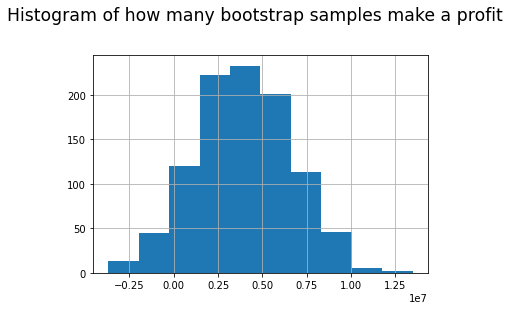

In [23]:
bs0 = bs_profit(target_test0, predicted_values0)

Wells that make a profit: 985
Proportion of wells that make a profit: 0.985


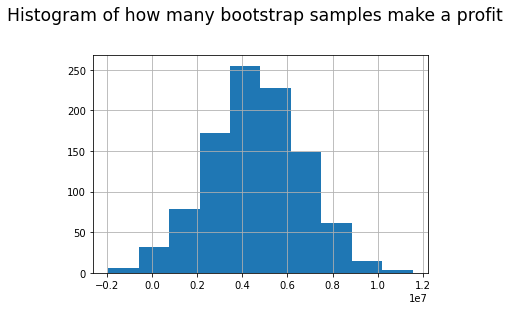

In [24]:
bs1 = bs_profit(target_test1, predicted_values1)

Wells that make a profit: 924
Proportion of wells that make a profit: 0.924


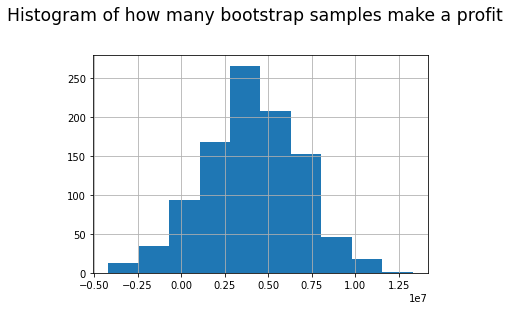

In [25]:
bs2 = bs_profit(target_test2, predicted_values2)

<div class="alert alert-info">
    <h3>Histogram Summary</h3>
        <p>The histograms above are showing us that it is highly unlikely for us the developer to make a loss. Bootstrapping with 1000 iterations gives us good confidence since there is a nice curve that follows the normal distribution.</p>
</div>


<div class="alert alert-info">
    <h3>Quantile Way</h3>
        <p>So I initially computed the confidence interval using the scipy library but I did more research and on a few youtube tutorials and further research I kept seeing people say that the Quantile method is more appropriate. So I tried it below.</p>
</div>

In [26]:
conf_int(bs0)
bs_conf_int(bs0)

The average profit for this region is:  3961649.8480237117
The 95% confidence interval is: 3796203.1514797257 , 4127096.5445676977
The risk of losses is 0.069
Confidence interval from the quantile method: -1112155.4589049604 , 9097669.41553423


In [27]:
conf_int(bs1)
bs_conf_int(bs1)

The average profit for this region is:  4560451.057866608
The 95% confidence interval is: 4431472.486639005 , 4689429.62909421
The risk of losses is 0.015
Confidence interval from the quantile method: 338205.0939898458 , 8522894.538660347


In [28]:
conf_int(bs2)
bs_conf_int(bs2)

The average profit for this region is:  4044038.665683568
The 95% confidence interval is: 3874457.974712804 , 4213619.356654332
The risk of losses is 0.076
Confidence interval from the quantile method: -1633504.1339559986 , 9503595.749237997


<div class="alert alert-info">
    <h2>Findings</h2>
        <p>I was surprised to see the results we got from bootstrapping are different from the one we got in doing linear regression. This may be because the second region has a better R squared value which means it can consistently make profits while the first region cannot. The quality of the models was evaluated and we got good r squared metrics for each regions model we found out that the volume of reserves is sufficient for developing a new well without losses which is 111.11. Then Bootstrapping gave us better insight into the investment the company should make. Even though all regions have a good profit prediction the risk of loss is the lowest in the second region which means there is a clear winner in the region we should dig 200 wells in.</p>
</div>


